# <center>Predicting Mortgage Default</center>

### <center>BA-1-1 Wenbin Zhou (周文斌)</center>
---
### <center>zhouwenbin@mail.ustc.edu.cn</center>

---
### Intro
Before I start, I want to list some tricky problems that I encountered that wasn't clarified in the description of this assignment:
1. In "mortgage_data.csv", at column "fthb_flg", aside from the value "N" and "Y", there are also "U"s, which isn't defined in the file "Mortgage Data Description".
2. According to our assignment description, we are suppose to include the respective changes from a year ago of interest rates as features. But "rate.csv" only provides data *starting from* 2000. So it is impossible to fill in the value of this feature for (training) datas originating in 2000.

These problems might affect the precision of my prediction model. How I dealt with them is that for the first problem, I took "U" as another categorial value, making the feature "fthb_flg" into a three dimensional dummy vector. For the second problem, I simply defined "the change from a year ago" features to be zero (I know this could be inaccurate but I had no other choice). Hope these won't mess up my results :(

### Question a

***Solution:***
We start off building the logistic regression model by making some preparations.

In [1]:
import pandas as pd # Extract data and manipulate data
import datetime # Used especially to deal with the time series in "frst_dte"
import numpy as np

np.set_printoptions(threshold=np.inf) # for convenience of showing the result

# Read in the files

features=['source','Quarter_orig','orig_rt','oltv','ocltv','dti','cscore_b','mi_pct','fthb_flg','num_bo','num_unit','1yr_hpi','3yr_hpi','1yr_frm','1yr_rate','FRM30_rate','treasury_3mon_rate']
df1 = pd.read_csv('mortgage_data.csv', low_memory = False)
df2 = pd.read_csv('hpi_state.csv', low_memory = False)
df3 = pd.read_csv('rate.csv', low_memory = False)

# Extract the implicit features

# Based on "Notes" in Description.pdf, we generate the month of origination data as follows
df1['Month_orig'] = df1['frst_dte'].apply(lambda x: int((datetime.datetime.strptime(x,'%m/%d/%Y')+datetime.timedelta(days=-45)).strftime('%m')))
df2['1yr_hpi'] = df2['HPI_state']-df2['HPI_state'].shift(4) # Past one year house price growth at state level
df2['3yr_hpi'] = df2['HPI_state']-df2['HPI_state'].shift(12) # Past three year house price growth at state level
df3['1yr_frm'] = df3['FRM30_rate']-df3['FRM30_rate'].shift(12) # Respective changes from a year ago
df3['1yr_rate'] = df3['treasury_3mon_rate']-df3['treasury_3mon_rate'].shift(12) # Respective changes from a year ago
df3.fillna(0,inplace=True) # Fill in NaN with 0 because there is a problem here! Check it out in the intro

# Merge the files

df4 = pd.merge(df1,df2,left_on=['Year_orig','state','Quarter_orig'] ,right_on=['year','state','quarter'])
df = pd.merge(df4,df3,left_on=['year','Month_orig'], right_on=['year','month'],sort=True)
# df now contains all the data that we need, sort is to ensure that the order stays the same

data = pd.get_dummies(df[features]) # Convert to one-hot encoded data

# Check and record new column names

print(data.head())

   Quarter_orig  orig_rt  oltv  ocltv  dti  cscore_b  mi_pct  num_bo  \
0             1    8.500    95     95   43       698      25       2   
1             1    8.500    95     95   41       621      30       2   
2             1    7.750    95     95   47       734      30       1   
3             1    8.375    69     69   46       775       0       1   
4             1    8.125    80     80   28       716       0       2   

   num_unit  1yr_hpi   3yr_hpi  1yr_frm  1yr_rate  FRM30_rate  \
0         1  3.09999  13.19001      0.0       0.0        8.21   
1         1  3.09999  13.19001      0.0       0.0        8.21   
2         1  3.09999  13.19001      0.0       0.0        8.21   
3         1  3.09999  13.19001      0.0       0.0        8.21   
4         1  3.55000  20.50000      0.0       0.0        8.21   

   treasury_3mon_rate  source_FD  source_FN  fthb_flg_N  fthb_flg_U  \
0                5.32          1          0           1           0   
1                5.32          0  

This looks excellent, we will write down the new column-names into ```new_features```. We would also like the data to be converted to mean zero and unit standard deviation for better performance of this algorithm.

In [2]:
new_features = ['source_FD','source_FN','Quarter_orig','orig_rt','oltv','ocltv','dti','cscore_b','mi_pct','fthb_flg_N','fthb_flg_U','fthb_flg_Y','num_bo','num_unit','1yr_hpi','3yr_hpi','1yr_frm','1yr_rate','FRM30_rate','treasury_3mon_rate']

# Normalization

from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
data_scaler=scaler.fit(data[new_features])
data_scaled=pd.DataFrame(data_scaler.transform(data[new_features]), columns=data[new_features].columns)

# Check

print(data_scaled.head())

   source_FD  source_FN  Quarter_orig   orig_rt      oltv     ocltv       dti  \
0   1.070302  -1.070302     -1.471143  2.025284  1.049232  0.913449  0.646201   
1  -0.934316   0.934316     -1.471143  2.025284  1.049232  0.913449  0.472455   
2  -0.934316   0.934316     -1.471143  1.205996  1.049232  0.913449  0.993692   
3  -0.934316   0.934316     -1.471143  1.888736 -0.769360 -0.861388  0.906819   
4   1.070302  -1.070302     -1.471143  1.615640  0.000045 -0.110495 -0.656891   

   cscore_b    mi_pct  fthb_flg_N  fthb_flg_U  fthb_flg_Y    num_bo  num_unit  \
0 -0.450978  1.215144    0.567632   -0.021381   -0.566928  0.818413 -0.124793   
1 -1.851044  1.601983   -1.761706   -0.021381    1.763893  0.818413 -0.124793   
2  0.203599  1.601983    0.567632   -0.021381   -0.566928 -1.221877 -0.124793   
3  0.949088 -0.719049    0.567632   -0.021381   -0.566928 -1.221877 -0.124793   
4 -0.123690 -0.719049    0.567632   -0.021381   -0.566928  0.818413 -0.124793   

    1yr_hpi   3yr_hpi   1y

Now, we generate the training data set and test data set using the ```train_test_split``` function. Notice that I'm stratifying the selection according to the feature "year".

In [3]:
# Generate desired data sets

from sklearn.model_selection import train_test_split

y = df['delinquent30'] # These are the labels
X = data_scaled # These are the features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33,stratify=df['Year_orig']) # Split into 1:2 by year

# Check

print(X_train.head())

        source_FD  source_FN  Quarter_orig   orig_rt      oltv     ocltv  \
39368   -0.934316   0.934316      1.388810  1.342544  0.000045 -0.110495   
42254   -0.934316   0.934316      1.388810  1.752188 -4.126760 -4.138011   
231223  -0.934316   0.934316      1.388810 -0.978770 -1.888493 -1.953596   
58081   -0.934316   0.934316     -1.471143  0.523257  0.979286  0.845186   
52112   -0.934316   0.934316     -1.471143  1.069448  0.489665  0.367345   

             dti  cscore_b    mi_pct  fthb_flg_N  fthb_flg_U  fthb_flg_Y  \
39368   0.038091 -0.287334 -0.719049    0.567632   -0.021381   -0.566928   
42254  -0.396273 -2.923822 -0.719049    0.567632   -0.021381   -0.566928   
231223 -1.612492  0.785444 -0.719049   -1.761706   -0.021381    1.763893   
58081   0.733074 -1.123737  1.601983    0.567632   -0.021381   -0.566928   
52112  -0.830637 -0.887362  1.215144   -1.761706   -0.021381    1.763893   

          num_bo  num_unit   1yr_hpi   3yr_hpi   1yr_frm  1yr_rate  \
39368   0.818413

The very left column denotes the index of the data, which will vary between different runs since the ```train_test_split``` function selects data randomly, so don't worry about it. Next, plug in the train data and run the logistic regression and print out the weight vector, whose magnitude (a.k.a. absolute value) positively reflects the importance of the corresponding feature in determining the default rate.

In [4]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1e5, solver='sag', max_iter=100) # solver "sag" is efficient in dealing with large data sets
logreg.fit(X_train, y_train)

print(logreg.coef_)

[[-0.04714481  0.04714481  0.0125136   0.23686855  0.0248317   0.0146417
   0.07789153 -0.71718839  0.10235934  0.03691622  0.0039639  -0.03713718
  -0.25362269  0.02616895 -0.11103238  0.12502353  0.02544195 -0.03650441
  -0.35487008  0.15411015]]


By comparing the absolute value of the coefficient of the respective features, we can conclude a list showing the top 5 most important features.
1. cscore_b: credit score at the origination date
2. FRM30_rate: current 30-year fixed mortgage rate 
3. num_bo: number of borrowers
4. treasury_3mon_rate: current 3-month treasury bill rate
5. 3yr_hpi: past 3-year house price growth at state level

We can use the test data to see how well the logistic model fits our train data. Keep in mind that we are using "0", which is "not delinquent", as our null hypothesis.

In [5]:
# Predict X_test

result=logreg.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test,result,digits=3))

              precision    recall  f1-score   support

           0      0.885     0.996     0.938     86084
           1      0.504     0.028     0.053     11409

    accuracy                          0.883     97493
   macro avg      0.695     0.512     0.495     97493
weighted avg      0.841     0.883     0.834     97493



We can also obtain a confusion matrix for this result.

In [6]:
from sklearn.metrics import confusion_matrix
 
C=confusion_matrix(result, y_test)
print('Confusion matrix\n',C)

# Calculate type one and type two error rate

N=C[0][0]+C[0][1]
P=C[1][0]+C[1][1]
I=C[0][1]/N
II=C[1][0]/P
All=(C[0][1]+C[1][0])/(N+P)

print('Type I error rate:',format(I,'.2%'))
print('Type II error rate:',format(II,'.2%'))
print('Overall error rate:',format(All,'.2%'))

Confusion matrix
 [[85771 11091]
 [  313   318]]
Type I error rate: 11.45%
Type II error rate: 49.60%
Overall error rate: 11.70%


As shown in the classification report, the f1-score for 0 (not delinquent) is 0.937, which is very high compared to 1 (delinquent)'s f1-score of 0.047. What it basically tells us is that, the model is good at dealing with mortgage that are not likely to go delinquent, but is horrible at determining the ones that might go delinquent.

We have to admit there are some other factors in place. For example, the data is really sparse, meaning that out of around 200 thousand training datas there are only about 1 thousand of them are labeled "delinquent", which is quite few compared to the "not delinquent" ones, so it is not surprising that the type II error turned out to be way higher than type I error. Additionally, what we are dealing with are raw realistic datas accompanied by a lot of uncertainty. This explains why we get a relatively inaccurate result.

---

### Question b

***Solution:***
We can obtain the desired graph using the ```roc_curve``` function, 

<Figure size 432x288 with 0 Axes>

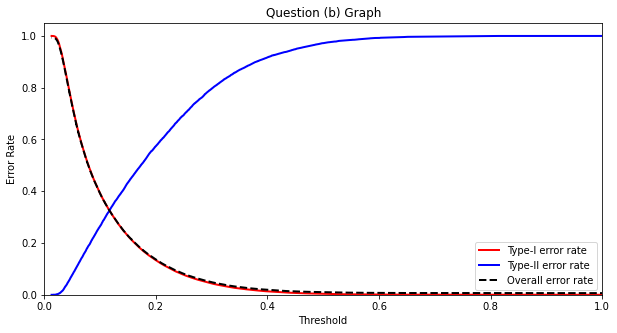

In [7]:
# Plot the desired functions

y_prob=logreg.predict_proba(X_test)[::,1] # Obtain scores of the test set for the roc_curve function to refer to

from sklearn.metrics import roc_curve, auc
fpr,tpr,threshold = roc_curve(y_test, y_prob) # False positive rate and true positive rate (1 - false negative rate)

oaer=N/(N+P)*(fpr) + P/(N+P)*(1-tpr) # Overall error rate

import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.figure(figsize=(10,5))
plt.plot(threshold,fpr, color='red',lw=lw, label='Type-I error rate') # aka False positive rate curve
plt.plot(threshold,1-tpr, color='blue',lw=lw, label='Type-II error rate') # aka False negative rate curve

plt.plot(threshold,oaer, color='black', lw=lw, label='Overall error rate', linestyle = '--') # Overall error rate curve

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Question (b) Graph')
plt.legend(loc="lower right")
plt.show()

The reason why the Overall error rate is strongly correlated to Type-I error rate is that the data we are dealing with is sparse, meaning that there are only a tiny part of people that are "delinquent" compared to the "not delinquent ones". So by tuning up the threshold, meaning to classifying everybody as "not deliquent", the overall error rate is going to go down, because the majority of the people have been calssified correctly! As a by-product, we can also easily obtain the ROC curve for our model.

<Figure size 432x288 with 0 Axes>

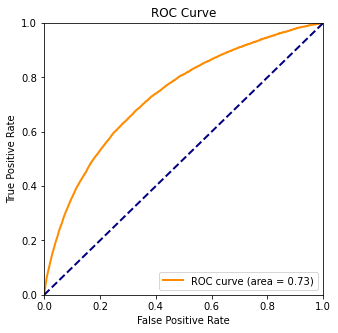

In [8]:
# Plot the ROC curve

roc_auc = auc(fpr,tpr) # Calculate the value for auc

plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc) # The orange curve
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed blue line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Question c

***Solution:***
Redo Question a, b using KNN model. It is crucial to determine the value of k, and we use cross validation to address this problem. The idea is, we apply KNN to cross validation with different Ks, and figure out the optimal K that makes the test scores mean reaches its minimum. This process will be done by plotting a scores mean-K value graph. Notice that I'm only using the first 1000 datas here because any larger sets will make convergence fairly hard. Also, I think that the data we are dealing with shouldn't be calssified as time series data, so we are using k-fold cross validation.

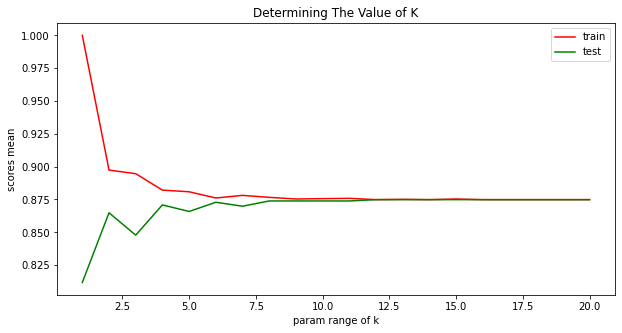

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve

param_name = 'n_neighbors' # Testing on "n_neighbors"
param_range = range(1,21) # K will range from 1 to 31

train_score, test_score=validation_curve(KNeighborsClassifier(), X_train[1:1000], y_train[1:1000], cv=5, param_name=param_name, param_range=param_range, scoring='accuracy')
# Divide training dataset into 5 folds, use "accuracy" for scoring

train_score_mean = np.mean(train_score, axis=1)
test_score_mean = np.mean(test_score, axis=1)

plt.figure(figsize=(10,5))
plt.plot(param_range, train_score_mean, color='red', label='train')
plt.plot(param_range, test_score_mean, color='green', label='test')
plt.legend()
plt.xlabel('param range of k')
plt.ylabel('scores mean')
plt.title('Determining The Value of K')
plt.show()

As shown in the graph, K=10 should be a nice choice for our KNN model. Next, we march into the prediction part. PS: The following parts might take some time to run since there are many calculations!

In [10]:
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)

result1=knn.predict(X_test)
print(classification_report(y_test,result1,digits=3))

              precision    recall  f1-score   support

           0      0.885     0.995     0.937     86084
           1      0.403     0.026     0.049     11409

    accuracy                          0.882     97493
   macro avg      0.644     0.510     0.493     97493
weighted avg      0.829     0.882     0.833     97493



We can also construct the confusion matrix.

In [11]:
C1=confusion_matrix(result1, y_test)
print('Confusion matrix\n',C1)

# Calculate type one and type two error rate

N1=C1[0][0]+C1[0][1]
P1=C1[1][0]+C1[1][1]
I1=C1[0][1]/N1
II1=C1[1][0]/P1
All1=(C1[0][1]+C1[1][0])/(N1+P1)

print('Type I error rate:',format(I1,'.2%'))
print('Type II error rate:',format(II1,'.2%'))
print('Overall error rate:',format(All1,'.2%'))

Confusion matrix
 [[85643 11111]
 [  441   298]]
Type I error rate: 11.48%
Type II error rate: 59.68%
Overall error rate: 11.85%


The KNN model turns out to be almost the same as the logistic model. Each feature's f1-score turned out to be a little lower than its respective counterpart. Similar factors that effects the performance of this model apply as well, they were being discussed in the previous part.

In [12]:
# Plot the desired functions

y_prob1=knn.predict_proba(X_test)[::,1]

# I left this out as an individual cell for convenience

<Figure size 432x288 with 0 Axes>

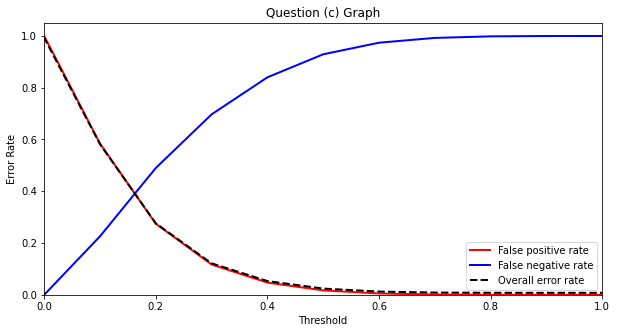

In [13]:
fpr1,tpr1,threshold1 = roc_curve(y_test, y_prob1)

oaer1=N1/(N1+P1)*(fpr1) + P1/(N1+P1)*(1-tpr1)

plt.figure()
lw = 2
plt.figure(figsize=(10,5))
plt.plot(threshold1,fpr1, color='red',lw=lw, label='False positive rate')
plt.plot(threshold1,1-tpr1, color='blue',lw=lw, label='False negative rate')

plt.plot(threshold1,oaer1, color='black', lw=lw, label='Overall error rate', linestyle = '--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Question (c) Graph')
plt.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

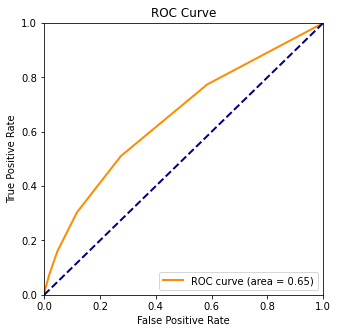

In [14]:
# Plot the ROC curve

roc_auc1 = auc(fpr1,tpr1) # Calculate the value for auc

plt.figure()
lw = 2
plt.figure(figsize=(5,5))
plt.plot(fpr1, tpr1, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc1) # The orange curve
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') # The dashed blue line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

It seems like that KNN doesn't perform as well as our logit model. Notice that the threshold value only takes 1-digit decimals, making the curve look rougher than the former one, but in the whole similar.

### Question d (Bonus)

To realize  feature selection, we need to set the parameter ```penalty``` to ```l1```, which is the so-called LASSO feature selection technique (L1 regularization). Smaller ```C``` generates stronger regulization. We need to first decide on what value we pick for C makes the model the best, and we use cross validation for that.

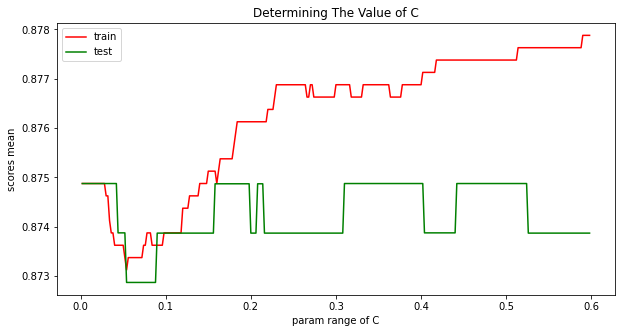

In [15]:
param_name = 'C' # Testing on "C"
param_range = np.array(range(1,300))/500 # C will range from 0.002 to 0.6

dlasso = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)

train_score, test_score=validation_curve(dlasso, X_train[1:1000], y_train[1:1000], cv=5, param_name=param_name, param_range=param_range, scoring='accuracy')
# Divide training dataset into 5 folds, use "accuracy" for scoring

train_score_mean = np.mean(train_score, axis=1)
test_score_mean = np.mean(test_score, axis=1)

plt.figure(figsize=(10,5))
plt.plot(param_range, train_score_mean, color='red', label='train')
plt.plot(param_range, test_score_mean, color='green', label='test')
plt.legend()
plt.xlabel('param range of C')
plt.ylabel('scores mean')
plt.title('Determining The Value of C')
plt.show()

Lets set ```C=0.005```, which makes the model performance reaches its maximum as shown in the graph. Quite a lot of interesting differences took place in the result.

In [16]:
lasso = LogisticRegression(penalty='l1', C=0.005, solver='saga', max_iter=1000) # only "saga" can deal with large data sets & l1 penalty
lasso.fit(X_train, y_train)

print(lasso.coef_)

[[-0.03962702  0.03962702  0.01231175  0.12156845  0.01442596  0.01555865
   0.07420348 -0.71261042  0.104031    0.          0.         -0.05775008
  -0.2477891   0.01953426  0.          0.02016924  0.          0.00608865
  -0.16503865  0.07393405]]


Zeroes started to appear in the weight vector. Another thing that is astonshing is that now the "top 5 most important default indicators" has changed! For example, now the second on the rank is ```num_bo```, which is the third before we introduced LASSO. Next, generate a classification report for our new logit model.

In [17]:
result_lasso=lasso.predict(X_test)
print(classification_report(y_test,result_lasso,digits=3))

              precision    recall  f1-score   support

           0      0.885     0.997     0.938     86084
           1      0.490     0.021     0.040     11409

    accuracy                          0.883     97493
   macro avg      0.687     0.509     0.489     97493
weighted avg      0.839     0.883     0.833     97493



As shown in the chart, performing feature selection doesn't help improve the model's performance in the test set.

<Figure size 432x288 with 0 Axes>

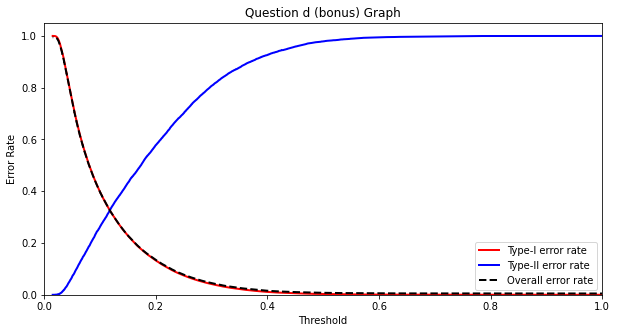

In [18]:
C2=confusion_matrix(result_lasso, y_test)

# Calculate type one and type two error rate

N2=C2[0][0]+C2[0][1]
P2=C2[1][0]+C2[1][1]
I2=C2[0][1]/N2
II2=C2[1][0]/P2
All2=(C[0][1]+C2[1][0])/(N2+P2)

# Plot the desired functions

y_prob2=lasso.predict_proba(X_test)[::,1] # Obtain scores of the test set for the roc_curve function to refer to

fpr2,tpr2,threshold2 = roc_curve(y_test, y_prob2) # False positive rate and true positive rate (1 - false negative rate)

oaer2=N2/(N2+P2)*(fpr2) + P2/(N2+P2)*(1-tpr2) # Overall error rate

plt.figure()
lw = 2
plt.figure(figsize=(10,5))
plt.plot(threshold2,fpr2, color='red',lw=lw, label='Type-I error rate') # aka False positive rate curve
plt.plot(threshold2,1-tpr2, color='blue',lw=lw, label='Type-II error rate') # aka False negative rate curve

plt.plot(threshold2,oaer2, color='black', lw=lw, label='Overall error rate', linestyle = '--') # Overall error rate curve

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Error Rate')
plt.title('Question d (bonus) Graph')
plt.legend(loc="lower right")
plt.show()

No obvious difference has been shown in our graph.

### Summary

It is suprising to me that the elementary logistic regression did just as good as KNN and LASSO regression, however, I'm not content with the performance of the model. There might be noises and other factors but I believe there is another way to improve the work I've done, which, I'm guessing, introducing a neural network should be a better solution? But anyways, I think this project is very meaningful to me, since this is my first time working on such a large python project (I major in statistics and had just completed my sophmore year of study so I don't get to code a lot with python) and I've learned a lot from the lectures as well as during this individual assignment. Machine learning is fun!
